In [1]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
processing_date = "2022-11-22"

In [2]:
results = pd.concat([
    pd.read_csv("./results/2022-11-14-timing-ecga-nasbench_lim-8e78f7b-archive.csv.gz"),
    pd.read_csv("./results/2022-11-15-timing-ecga-nasbench-6_lim-30ae8d0-archive.csv.gz"),
    # pd.read_csv("./results/2022-11-14-timing-ga-nasbench_lim-8e78f7b-archive.csv.gz"), -- incorrect mutation
    pd.read_csv("./results/2022-11-22-timing-ga-nasbench_lim-292e8e5-archive.csv.gz"),
    pd.read_csv("./results/2022-11-14-timing-gomea-nasbench_lim-8e78f7b-archive.csv.gz")
])

remapping_algorithm_type = {
    "sync": "ecga-sync",
    "async-throttled": "ecga-async-th",
}
results["algorithm_type"] = results["algorithm_type"].replace(remapping_algorithm_type)

vtr = results.iloc[0]["vtr"]

configuration_columns = ["replacement_strategy", "tournament_size", "algorithm_type"]
problem_columns = ["problem"]
run_columns = ["seed"]

In [3]:
results_hit = (results.
    sort_values("simulation time (s)").
    groupby(configuration_columns + problem_columns + run_columns).
    last().
    reset_index())

In [4]:
results_hit["configuration"] = ["_".join(str(rv) for rv in r[configuration_columns]) for _, r in results_hit.iterrows()]

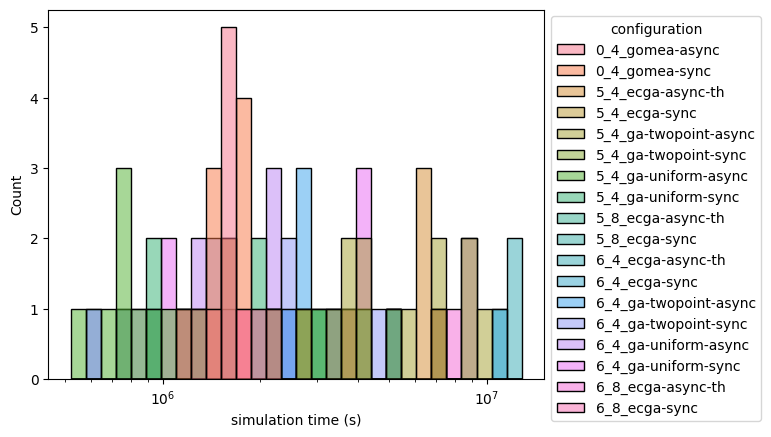

In [5]:
ax = sns.histplot(data=results_hit, x="simulation time (s)", hue="configuration", log_scale=(True, False), bins=30)
sns.move_legend(ax, bbox_to_anchor=(1,1), loc="upper left")

In [6]:
results_hit.groupby(configuration_columns)["simulation time (s)"].count().rename("successes").reset_index().style

,replacement_strategy,tournament_size,algorithm_type,successes
0,0,4,gomea-async,10
1,0,4,gomea-sync,10
2,5,4,ecga-async-th,4
3,5,4,ecga-sync,0
4,5,4,ga-twopoint-async,10
5,5,4,ga-twopoint-sync,8
6,5,4,ga-uniform-async,10
7,5,4,ga-uniform-sync,10
8,5,8,ecga-async-th,1
9,5,8,ecga-sync,0


In [7]:
tab = results_hit.groupby(configuration_columns)["simulation time (s)"].median().reset_index().style.format(na_rep="-", precision=0)
tab.to_excel("results-nasbench-timing.xlsx")
tab

,replacement_strategy,tournament_size,algorithm_type,simulation time (s)
0,0,4,gomea-async,1638275
1,0,4,gomea-sync,1568393
2,5,4,ecga-async-th,6500376
3,5,4,ecga-sync,-
4,5,4,ga-twopoint-async,4258886
5,5,4,ga-twopoint-sync,4081455
6,5,4,ga-uniform-async,824611
7,5,4,ga-uniform-sync,1445675
8,5,8,ecga-async-th,7135425
9,5,8,ecga-sync,-


In [21]:
tab_ss = results_hit.groupby(configuration_columns)["simulation time (s)"].median()
tab_ss = (tab_ss / 10**6).rename("simulation time (s) × 10^6")
tab_ss

replacement_strategy  tournament_size  algorithm_type   
0                     4                gomea-async          1.638275
                                       gomea-sync           1.568393
5                     4                ecga-async-th        6.500376
                                       ecga-sync                 NaN
                                       ga-twopoint-async    4.258886
                                       ga-twopoint-sync     4.081455
                                       ga-uniform-async     0.824611
                                       ga-uniform-sync      1.445675
                      8                ecga-async-th        7.135425
                                       ecga-sync                 NaN
6                     4                ecga-async-th        4.199536
                                       ecga-sync                 NaN
                                       ga-twopoint-async    2.731322
                                       ga-twop

In [25]:
tab_ps = results_hit.groupby(configuration_columns)["population_size"].median().rename("population size")
tab_ps

replacement_strategy  tournament_size  algorithm_type   
0                     4                gomea-async            60.0
                                       gomea-sync             55.5
5                     4                ecga-async-th        4096.0
                                       ecga-sync               NaN
                                       ga-twopoint-async    1024.0
                                       ga-twopoint-sync      768.0
                                       ga-uniform-async      244.0
                                       ga-uniform-sync       368.5
                      8                ecga-async-th        4096.0
                                       ecga-sync               NaN
6                     4                ecga-async-th        2048.0
                                       ecga-sync               NaN
                                       ga-twopoint-async    1024.0
                                       ga-twopoint-sync     1536.0
     

In [55]:
tab_c = pd.concat([tab_ps, tab_ss], axis=1).style.format({"population size": "{:0.1f}", "simulation time (s) × 10^6": "{:0.2f}"}, na_rep="-")
tab_c.to_excel(f"{processing_date}-results-nasbench-timed.xlsx")